In [73]:
# importing packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,OrdinalEncoder,StandardScaler
from collections import defaultdict
labelEncoder_dict = defaultdict(LabelEncoder)
from scipy import stats 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn import svm

## Data Cleaning

In [74]:
# Loading file data
df = pd.read_csv("stackoverflow_data.csv")
X = pd.DataFrame()

/opt/homebrew/Caskroom/miniforge/base/envs/stack-overflow-developer-survey-analysis/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [75]:
X['OpenSource'] = df['OpenSource'].eq('Yes').mul(1)
X['Hobby'] = df['Hobby'].eq('Yes').mul(1)
X['Student'] = df['Student'].str.contains('Yes').mul(1)

In [76]:
# YearsCoding
YearCodingMap = {
    '3-5 years':4,
    '30 or more years':30, 
    '24-26 years':25, 
    '18-20 years':19,
    '6-8 years':7, 
    '9-11 years':10, 
    '0-2 years':1,
    '15-17 years':16,
    '12-14 years':13, 
    '21-23 years':22, 
    '27-29 years':28,
}
X['YearsCoding'] = df['YearsCoding'].replace(YearCodingMap)
X['YearsCoding'].fillna(X['YearsCoding'].mean(),inplace=True)

In [77]:
companySizeMap = {
    '20 to 99 employees':60,
    '10,000 or more employees':10000,
    '100 to 499 employees':300, 
    '10 to 19 employees':15,
    '500 to 999 employees':750, 
    '1,000 to 4,999 employees':3000,
    '5,000 to 9,999 employees':7500, 
    'Fewer than 10 employees':10
}
X['CompanySize'] = df['CompanySize'].replace(companySizeMap)
X.dropna(subset=["CompanySize"],inplace=True) #Droping NaN values

In [78]:
# Formal Education
dummy1 = pd.get_dummies(df['FormalEducation'], drop_first=True) 
dummy1.drop(['I never completed any formal education','Primary/elementary school','Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)','Some college/university study without earning a degree'],axis=1,inplace=True)
X.join(dummy1)

,OpenSource,Hobby,Student,YearsCoding,CompanySize,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Master’s degree (MA, MS, M.Eng., MBA, etc.)","Other doctoral degree (Ph.D, Ed.D., etc.)","Professional degree (JD, MD, etc.)"
0,0,1,0,4.0,60.0,1,0,0,0
1,1,1,0,30.0,10000.0,1,0,0,0
2,1,1,0,25.0,60.0,0,0,0,0
3,0,0,0,19.0,300.0,1,0,0,0
4,0,1,1,7.0,10000.0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
71526,0,1,0,7.0,10.0,0,0,0,0
71527,0,1,1,4.0,750.0,1,0,0,0
71528,0,1,0,10.0,10.0,1,0,0,0
71529,1,1,0,7.0,10000.0,1,0,0,0


In [79]:
# AssessJob and Benefits Added
df.fillna(df.iloc[:,17:38].mean(),inplace=True)
for col in df.iloc[:,17:38].columns:
    X[col] = df[col]



In [80]:
# JobSatisfaction Mapping
SatisfactionMapping = {
    'Extremely satisfied':6,
    'Moderately satisfied':5, 
    'Slightly satisfied':4,
    'Neither satisfied nor dissatisfied':3,
    'Moderately dissatisfied':2,
    'Slightly dissatisfied':1,
    'Extremely dissatisfied':0
}

df['JobSatisfaction'].replace(SatisfactionMapping,inplace=True)
df.fillna({'JobSatisfaction':3},inplace=True)
X['JobSatisfaction'] = df['JobSatisfaction']

# CareerSatisfaction
df['CareerSatisfaction'].replace(SatisfactionMapping,inplace=True)
df.fillna({'CareerSatisfaction':3},inplace=True)
X['CareerSatisfaction'] = df['CareerSatisfaction']



In [81]:
# HackathonReasons
X['HackathonParticipated'] = df['HackathonReasons'].notna()*1

# ConvertedSalary
X['ConvertedSalary'] = df['ConvertedSalary']
X.dropna(subset=["ConvertedSalary"],inplace=True) #Droping NaN values


### One Hot Encoding

In [82]:
def CustomOneHotEncoding(data,X):
    temp = data.str.split(';', expand=True)
    new_columns = pd.unique(temp.values.ravel())
    for col in new_columns:
        if col is not None and col is not np.NaN:
            X[col] = data.str.contains(col, regex=False).fillna(False)*1

In [83]:
# LanguageWorkedWith
CustomOneHotEncoding(df['LanguageWorkedWith'],X)


CustomOneHotEncoding(df['DevType'],X)

CustomOneHotEncoding(df['DatabaseWorkedWith'],X)

CustomOneHotEncoding(df['PlatformWorkedWith'],X)

CustomOneHotEncoding(df['FrameworkWorkedWith'],X)

CustomOneHotEncoding(df['IDE'],X)

# Methodology
CustomOneHotEncoding(df['Methodology'],X)

# RaceEthnicity
CustomOneHotEncoding(df['RaceEthnicity'],X)

# CustomOneHotEncoding(df['Methodology'],X)


/var/folders/3h/smy7r7qj3wlgbhwx0plqyrph0000gn/T/ipykernel_86441/1202539500.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[col] = data.str.contains(col, regex=False).fillna(False)*1


In [84]:
# CheckInCode
CheckInCodeMapping = {
    'Multiple times per day':730, 
    'A few times per week':156, 
    'Weekly or a few times per month':52, 
    'Never':0,
    'Less than once per month':12, 
    'Once a day':365
}

X['CheckInCode'] = df['CheckInCode'].replace(CheckInCodeMapping)
X['CheckInCode'].fillna(X['CheckInCode'].mean(),inplace=True)

/var/folders/3h/smy7r7qj3wlgbhwx0plqyrph0000gn/T/ipykernel_86441/746842630.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X['CheckInCode'] = df['CheckInCode'].replace(CheckInCodeMapping)


In [85]:
AgeMapping = {
    '25 - 34 years old':29.5, 
    '35 - 44 years old':39.5, 
    '18 - 24 years old':21,
    '45 - 54 years old':49.5, 
    '55 - 64 years old':59.5, 
    'Under 18 years old':18,
    '65 years or older':65
}
X['Age'] = df['Age'].replace(AgeMapping)
X.dropna(subset=["Age"],inplace=True) #Droping NaN values

X['MilitaryUS'] = (df['MilitaryUS']=='Yes')*1
X['Dependents'] = (df['Dependents']=='Yes')*1
X['Gender'] = (df['Gender']=='Female')*1


/var/folders/3h/smy7r7qj3wlgbhwx0plqyrph0000gn/T/ipykernel_86441/1484029417.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X['Age'] = df['Age'].replace(AgeMapping)


In [86]:
# Exercise
ExerciseFreqMap = {
    '3 - 4 times per week':((3+4)/2)*52,
    'Daily or almost every day':365, 
    "I don't typically exercise":0, 
    '1 - 2 times per week':52
}
X['Exercise'] = df['Exercise'].replace(ExerciseFreqMap)
X['Exercise'].fillna(X['Exercise'].mean(),inplace=True)

# HoursCompMap
HoursCompMap = {
    '9 - 12 hours':10.5, 
    '5 - 8 hours':6.5, 
    'Over 12 hours':12, 
    '1 - 4 hours':2.5,
    'Less than 1 hour':1
}
X['HoursComputer'] = df['HoursComputer'].replace(HoursCompMap)
X['HoursComputer'].fillna(X['HoursComputer'].mean(),inplace=True)


In [87]:
# HypotheticalTools1-5
HypoToolMap = {
    'Extremely interested':5, 
    'Very interested':4, 
    'Somewhat interested':3, 
    'A little bit interested':2,
    'Not at all interested':1
}
hypotheticalToolsList = ['HypotheticalTools1','HypotheticalTools2','HypotheticalTools3','HypotheticalTools4','HypotheticalTools5']
for col in hypotheticalToolsList:
    X[col] = df[col].replace(HypoToolMap)
    X[col].fillna(X[col].median(),inplace=True)


In [88]:
# EducationParents -> Higher Educated Parents
EducatedParentsMap = {
    "Bachelor’s degree (BA, BS, B.Eng., etc.)":1,
    'Some college/university study without earning a degree':0,
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)':0,
    "Master’s degree (MA, MS, M.Eng., MBA, etc.)":1,
    'Primary/elementary school':0, 
    'Associate degree':1,
    'They never completed any formal education':0,
    'Other doctoral degree (Ph.D, Ed.D., etc.)':1,
    'Professional degree (JD, MD, etc.)':1
}
X['ParentsWithHighEducation'] = df['EducationParents'].replace(EducatedParentsMap)
X.dropna(subset=["ParentsWithHighEducation"],inplace=True) #Droping NaN values


# Hypothesis Testing

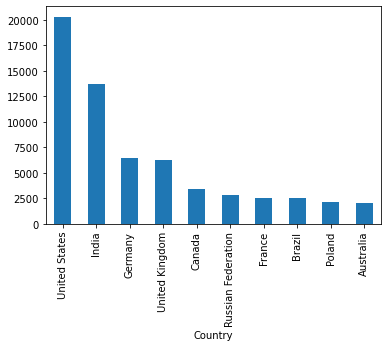

In [50]:
#Ads Hypothesis 81-94
#dOES PER cOUNTRY Criteria change(skills)
#Does college coding affect Salary
#Self Taught vs Formal Educated Developer does have Job/Career Satisfaction and more paid?
#Does Self Taught vs Formal Educated Developer have inferiority complex

df_country= (df.groupby(['Country'])).count()
df_country.sort_values(by=['Respondent'], ascending=False, inplace=True)

df_country.iloc[0:10, 0].plot.bar()


USPeople_df= df[df['Country']== 'United States']
IndianPeople_df= df[df['Country']== 'India']
USPeople_df=USPeople_df[['Country','JobSatisfaction']]
IndianPeople_df=IndianPeople_df[['Country','JobSatisfaction']]
#decide hypothesis Akash

In [ ]:
#%% Hypothesis for US male and female developers equally paid
#Code is designed in such way can compare for any country.


df_allgender=df.groupby(['Gender']).count()
df_allgender.sort_values(by=['Respondent'], ascending=False, inplace=True)
df_allgender.iloc[0:3, 0].plot.bar()

df_allgender=df_allgender.T
df_gender= df_allgender[['Female', 'Male']]
df_gender=df_gender.iloc[0, :]

df_female= df[df['Gender']== 'Female']
df_male= df[df['Gender']== 'Male']
femaleSalaries_df= df_female[['Country','Currency','CurrencySymbol','Salary']]
maleSalaries_df= df_male[['Country','Currency','CurrencySymbol','Salary']]


USFemaleSalaries=pd.DataFrame(femaleSalaries_df.groupby('Currency')['Salary'])
USMaleSalaries=pd.DataFrame(maleSalaries_df.groupby('Currency')['Salary'])
M1=USFemaleSalaries.iloc[18, 1]
M2=USMaleSalaries.iloc[18,1]

u,p1 = stats.mannwhitneyu(M1,M2)
k,p=stats.kstest(M1,M2)

# PCA

In [60]:
X.to_csv('stacknewdata.csv')

In [92]:
zscoredData = stats.zscore(X)

In [94]:
ans=[]
for i in range(zscoredData.shape[1]):    
    s=np.all(np.isfinite(zscoredData.iloc[:,i]))
    if s==False:
        ans.append(i)
np.all(np.isfinite(zscoredData))

[]


True

In [95]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

pca = PCA().fit(zscoredData)
eigValues = pca.explained_variance_
loadings_v = pca.components_
u = pca.fit_transform(zscoredData)
covarExplained = (sum(eigValues[:10])/sum(eigValues))*100
covarExplained

19.64248320970078

In [108]:
eigValues>1 #47 columns
X_transformed = u[:,0:50]
X_transformed.shape

(37268, 50)

Text(0, 0.5, 'Eigenvalues')

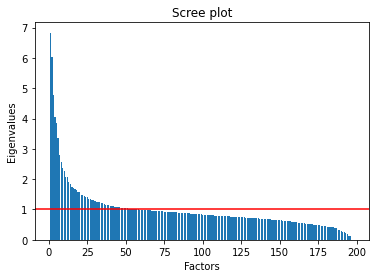

In [98]:
import matplotlib.pyplot as plt


numPredictors = X.shape[1]
plt.bar(np.linspace(1,numPredictors,numPredictors),eigValues)
plt.axhline(y=1, color='r', linestyle='-')
plt.title('Scree plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalues')

In [99]:
maxFeat=[]
for i in range(47):
    maxFeat.append(np.argmax(loadings_v[i,:]*-1))
maxFeat

[152,
 35,
 3,
 30,
 51,
 49,
 23,
 153,
 192,
 22,
 23,
 13,
 73,
 169,
 26,
 154,
 26,
 134,
 98,
 97,
 8,
 134,
 27,
 63,
 92,
 11,
 148,
 5,
 126,
 60,
 19,
 179,
 190,
 12,
 11,
 5,
 129,
 58,
 12,
 183,
 191,
 6,
 58,
 125,
 133,
 6,
 7]

# Clustering


In [101]:
X.loc[X['JobSatisfaction'] <= 3.0, 'JobSatisfaction'] = 0
X.loc[X['JobSatisfaction'] > 3.0, 'JobSatisfaction'] = 1
X['JobSatisfaction'].value_counts()

1.0    26184
0.0    11084
Name: JobSatisfaction, dtype: int64

In [ ]:
col=X_new.columns
for i in range(1):
    for j in range(i+1, 46):
        plt.figure()
        f1=col[i]
        f2=col[j]
        plt.scatter(u[:,i], u[:,j])
        plt.xlabel(f1)
        plt.ylabel(f2)
        plt.show()

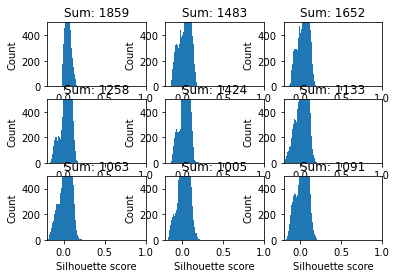

In [109]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

numClusters = 9 # how many clusters are we looping over? (from 2 to 10)
Q = np.empty([numClusters,1]) # init container to store sums
Q[:] = np.NaN # convert to NaN

ans=[]
plt.figure()
# Compute kMeans:
for ii in range(2, 11): # Loop through each cluster (from 2 to 10!)
    kMeans = KMeans(n_clusters = int(ii)).fit(X_transformed) # compute kmeans
    cId = kMeans.labels_ # vector of cluster IDs that the row belongs to
    cCoords = kMeans.cluster_centers_ # coordinate location for center of each cluster
    my_dict = {cCoords[i, 0]: np.where(cId== i)[0] for i in range(kMeans.n_clusters)}
    ans.append(my_dict)
    s = silhouette_samples(X_transformed,cId) # compute the mean silhouette coefficient of all samples
    # print(s.shape)
    Q[ii-2] = sum(s) # take sum
    # Plot data:
    plt.subplot(3,3,ii-1) 
    plt.hist(s,bins=100) 
    plt.xlim(-0.2,1)
    plt.ylim(0,500)
    plt.xlabel('Silhouette score')
    plt.ylabel('Count')
    plt.title('Sum: {}'.format(int(Q[ii-2])))

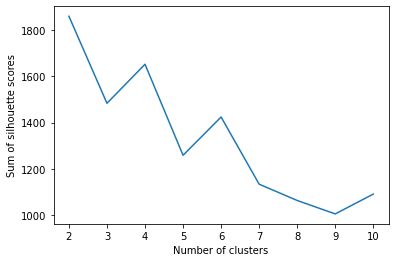

In [110]:
plt.figure()
plt.plot(np.linspace(2,10,numClusters),Q)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of silhouette scores')
plt.show()

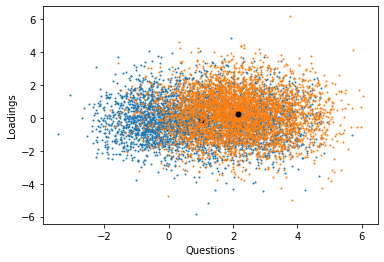

In [116]:
c= (np.argmax(Q)+2)
#Which two features do you want to visualize
v=[1,10]
plt.figure()
indexVector = np.linspace(1,c,c) 
for ii in indexVector:
    plotIndex = np.argwhere(cId == int(ii-1))
    plt.plot(u[plotIndex,v[0]],u[plotIndex,v[1]],'o',markersize=1)
    plt.plot(cCoords[int(ii-1),v[0]],cCoords[int(ii-1),v[1]],'o',markersize=5,color='black')  
    plt.xlabel('Questions')
    plt.ylabel('Loadings')

In [117]:
kMeans = KMeans(n_clusters = 2).fit(X_transformed)
y_pred=kMeans.fit_predict(X_transformed)
y_pred

array([0, 0, 1, ..., 1, 0, 1], dtype=int32)

In [121]:
X_transformed

array([[-0.65582361,  4.22758311, -2.87616555, ..., -0.04085362,
        -0.0751172 , -0.05645359],
       [-3.21155364, -0.76499316, -0.05054808, ...,  0.34909507,
        -1.82110003, -0.61218866],
       [ 0.04297345, -0.94510219,  0.11133587, ...,  0.10559831,
         0.05617848, -1.05613564],
       ...,
       [ 2.90850058, -1.7072548 ,  1.97331865, ..., -0.47827228,
         0.88988186,  0.22834215],
       [-3.00111858,  2.63392223,  2.37696217, ...,  0.39325299,
        -1.12506745, -1.39395958],
       [-3.41535937, -1.9819542 , -2.21831629, ..., -0.11331576,
        -0.15226387,  0.00423564]])

In [122]:
df=pd.DataFrame(X_transformed)
df['cluster']=y_pred
df['cluster'].value_counts()

1    24199
0    13069
Name: cluster, dtype: int64

In [37]:
X

,0,1,2,3,4,5,6,7,8,9,...,37,38,39,40,41,42,43,44,45,46
0,3.709982,0.112943,-2.212247,0.024471,1.071342,1.560644,-1.455095,1.572278,0.716899,-0.862091,...,1.024999,1.363455,0.840829,-1.339812,-0.070931,-0.524773,-0.908595,-0.493906,1.219663,-0.257402
1,-0.015257,3.290548,-2.433202,1.198268,-1.281687,0.443805,2.016810,-3.713421,-0.366938,-1.601194,...,0.787817,0.527868,0.890276,-0.584981,1.021295,2.272391,-1.572716,0.637223,-0.390513,2.160754
2,-4.021943,0.775619,-1.499950,-0.511123,1.261601,0.786272,0.856516,-0.700384,-0.287865,-0.106019,...,0.470044,0.582862,0.869394,0.922981,-0.460666,-0.017960,0.523032,0.737100,-0.519123,-0.245539
3,0.715903,-3.361822,-2.805428,0.544165,2.311937,0.233530,-2.000312,0.872428,0.843388,-0.972044,...,0.395808,-0.392007,-0.300569,0.338691,-0.195309,0.170568,-0.843690,-0.270000,-0.913062,-0.387687
4,0.273025,-1.072198,2.491464,4.673674,2.652502,-1.050616,-0.195147,-3.164708,1.181005,1.134838,...,0.846432,0.705415,1.392179,-0.238396,-1.032053,-1.150831,0.935803,-0.079069,0.359077,2.208858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98850,-5.337102,1.368598,1.008486,-0.288426,-1.008396,1.509426,-1.492096,1.274328,-0.146523,0.235097,...,-0.533608,0.710740,0.288659,0.548855,0.003895,-0.789217,0.055289,0.117527,0.224868,0.255297
98851,-4.984879,0.746179,0.558720,-0.145349,-0.899269,1.858773,-0.547125,1.012508,-0.270948,0.145347,...,0.392207,-0.785586,-0.639958,-0.160360,-0.052542,0.443119,-0.052864,0.127462,-0.448130,-0.677205
98852,-4.998065,1.075068,0.034154,-0.470396,-0.065680,0.768540,-0.342025,0.832752,-0.035525,0.276068,...,-0.494143,0.842325,0.394109,0.650063,0.203613,-0.444177,0.018017,0.154735,0.585000,0.596719
98853,-5.259953,1.056422,0.477437,-0.271816,-0.438348,1.033863,-0.882169,1.114986,0.101851,0.226775,...,-0.415078,0.535292,-0.084742,0.109212,-0.228152,-0.790408,-0.077983,-0.037699,-0.007036,0.472684


In [124]:
Y=X['JobSatisfaction']
Y

1        0.0
4        1.0
5        1.0
6        1.0
8        1.0
        ... 
71523    1.0
71524    1.0
71526    1.0
71529    1.0
71530    0.0
Name: JobSatisfaction, Length: 37268, dtype: float64

In [125]:
from sklearn.ensemble import RandomForestClassifier

X_train,X_test,y_train,y_test=train_test_split(X_transformed,Y)
clf=RandomForestClassifier()
clf.fit(X_train,y_train)
# y_hat=clf.predict(X_test,y_test)
print(clf.score(X_test, y_test))

0.8585381560588172


In [126]:
from sklearn.linear_model import LogisticRegression
clf=LogisticRegression()
clf.fit(X_train,y_train)
print(clf.score(X_test, y_test))

0.9022217451969519


In [127]:
from sklearn.svm import SVC
kernels = ['linear','rbf','poly']
for kernel in kernels:
    clf=SVC(kernel=kernel)
    clf.fit(X_train,y_train)
    print(kernel,clf.score(X_test, y_test))

linear 0.905119673714715
rbf 0.901148438338521
poly 0.8885907480948804


# Regression


In [19]:
X_new=X
X_new.shape

(37268, 200)

In [23]:
Y=X['ConvertedSalary']
Y

1         70841.0
4         21426.0
5         41671.0
6        120000.0
8        250000.0
           ...   
71523    134000.0
71524    165000.0
71526     64417.0
71529    160000.0
71530    107500.0
Name: ConvertedSalary, Length: 37268, dtype: float64

In [24]:
sc=StandardScaler()
sc.fit(X_new)
X_new=sc.transform(X_new)
X_train,X_test,y_train,y_test=train_test_split(X_new,Y)

# regr = svm.SVR(kernel='linear')
# regr.fit(X_train, y_train)
# y_hat=regr.predict(X_test)
# print(regr.score(X_test, y_test))
# pd.DataFrame(y_hat, y_test)


In [25]:
alphas = [0.0, 1e-8, 1e-5, 0.1, 1, 10]
alphaErrMap = {}
for alpha in alphas:
    reg = Ridge(alpha=alpha)
    reg.fit(X_train,y_train)
    df_Y_test_pred = reg.predict(X_test)
    testing_error = mean_squared_error(y_test, df_Y_test_pred)
    # iI) testing error
    print("testing error",alpha, testing_error)
    alphaErrMap[alpha] = testing_error

optimal_alpha = min(alphaErrMap, key=alphaErrMap.get)
print("optimal_alpha",optimal_alpha,alphaErrMap[optimal_alpha])
pd.DataFrame(df_Y_test_pred, y_test)

testing error 0.0 4.448188533675542e-19
testing error 1e-08 5.065824402899258e-10
testing error 1e-05 5.74026614577013e-09
testing error 0.1 0.5739615689293623
testing error 1 57.392134612696275
testing error 10 5735.193801718182
optimal_alpha 0.0 4.448188533675542e-19


,0
ConvertedSalary,
70000.0,70019.470285
75000.0,75018.243006
5636.0,5659.009576
83342.0,83334.213585
72209.0,72222.802992
...,...
5844.0,5856.691130
61194.0,61210.869209
27600.0,27660.438300


In [26]:
alphas = [1e-3, 1e-2, 1e-1, 1]

for alpha in alphas:
    est=make_pipeline(Lasso(alpha=alpha))
    est.fit(X_train, y_train)
    Y_hat=est.predict(X_test)
    print(est.score(X_test, y_test))


0.9999999735636078
0.9999999737104524
0.9999999751629719
0.9999999854859688


In [ ]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor()
regr.fit(X_train, y_train)
Y_hat=est.predict(X_test)
print(regr.score(X_test, y_test))
pd.DataFrame(Y_hat, y_test)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 10, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
results = cross_val_score(xg_reg, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
scores = np.absolute(results)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
# y_test_pred = xg_reg.predict(X_test)
# mse = mean_squared_error(y_test_pred, y_test)
# print(results, mse)


# Summary and Conclusions(EDA)